# Initialize Dask Client

In [1]:
from __future__ import annotations

from dask.distributed import Client

c = Client(n_workers=10, threads_per_worker=1)
c

/Users/chavlin/.pyenv/versions/3.10.11/envs/pyramid_sampler/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50672 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:50672/status,
Dashboard: http://127.0.0.1:50672/status,Workers: 10
Total threads: 10,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50673,Workers: 10
Dashboard: http://127.0.0.1:50672/status,Total threads: 10
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:50702,Total threads: 1
Dashboard: http://127.0.0.1:50705/status,Memory: 3.20 GiB
Nanny: tcp://127.0.0.1:50676,


# create a test image 

This will represent a pre-existing base, high-resolution image which we will subsequently downsample. 

In [2]:
import zarr

from pyramid_sampler import Downsampler, initialize_test_image

In [10]:
zarr_file = "test_image.zarr"
new_field = "field1"
base_res = (1024, 1024, 1024)
chunks = (64, 64, 64)
overwrite = True

In [11]:
zarr_store = zarr.group(zarr_file)
zarr_store

<zarr.hierarchy.Group '/'>

### actually write the image to disk

In [12]:
%%time
if 0 not in zarr_store[new_field] or overwrite:
    initialize_test_image(zarr_store, new_field, base_res, chunks=chunks)

/Users/chavlin/.pyenv/versions/3.10.11/envs/pyramid_sampler/lib/python3.10/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 10.61 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 6.89 s, sys: 728 ms, total: 7.62 s
Wall time: 9.15 s


In [13]:
zarr_store[new_field][0].info

Name,/field1/0
Type,zarr.core.Array
Data type,float64
Shape,"(1024, 1024, 1024)"
Chunk shape,"(64, 64, 64)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,8589934592 (8.0G)
No. bytes stored,7521006182 (7.0G)


## downsample the image 

In [14]:
zarr_file = "test_image.zarr"
ds = Downsampler(zarr_file, (2, 2, 2), base_res, chunks)

In [15]:
%%time
ds.downsample(10, new_field)

pyramid_sampler : [INFO ] 2024-10-02 14:41:27,546:  downsampling to level 1.
pyramid_sampler : [INFO ] 2024-10-02 14:41:29,305:  downsampling to level 2.
pyramid_sampler : [INFO ] 2024-10-02 14:41:29,531:  downsampling to level 3.
pyramid_sampler : [INFO ] 2024-10-02 14:41:29,584:  downsampling to level 4.
pyramid_sampler : [INFO ] 2024-10-02 14:41:29,621:  cannot subdivide further, stopping downsampling at level 4.


CPU times: user 791 ms, sys: 112 ms, total: 902 ms
Wall time: 2.08 s


In [16]:
zarr_store[new_field][1].info

Name,/field1/1
Type,zarr.core.Array
Data type,float64
Shape,"(512, 512, 512)"
Chunk shape,"(64, 64, 64)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,1073741824 (1.0G)
No. bytes stored,939492741 (896.0M)


In [17]:
zarr_store[new_field][2].info

Name,/field1/2
Type,zarr.core.Array
Data type,float64
Shape,"(256, 256, 256)"
Chunk shape,"(64, 64, 64)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,134217728 (128.0M)
No. bytes stored,113937490 (108.7M)


In [18]:
zarr_store[new_field][3].info

Name,/field1/3
Type,zarr.core.Array
Data type,float64
Shape,"(128, 128, 128)"
Chunk shape,"(64, 64, 64)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,16777216 (16.0M)
No. bytes stored,13700219 (13.1M)


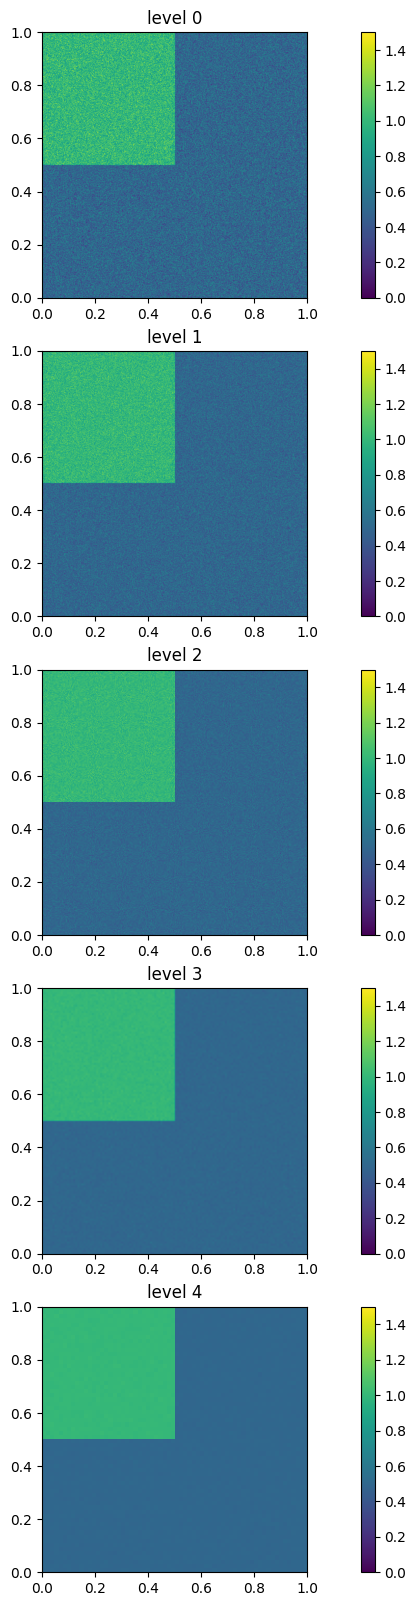

In [19]:
import matplotlib.pyplot as plt

n_arrays = len(list(zarr_store[new_field].array_keys()))
fig, axs = plt.subplots(nrows=n_arrays, ncols=1, figsize=(14, 20))

for level in zarr_store[new_field].array_keys():
    lev_shape = zarr_store[new_field][level].shape
    imhandle = axs[int(level)].imshow(
        zarr_store[new_field][level][:, :, lev_shape[-1] // 4], extent=(0, 1, 0, 1)
    )
    imhandle.set_clim(0, 1.5)
    axs[int(level)].set_title(f"level {level}")
    plt.colorbar(imhandle)